In [1]:
import matplotlib.pyplot as plt
import numpy as np

import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from grav_lens import get_datasets
from grav_lens.models import test_model_image

In [3]:
from os.path import join
home_data = join("..", "data")
max_files = 1000
batch_size = 16

train_dataset, val_dataset, test_dataset = get_datasets(data_index='1', max_files=max_files,
    home=home_data)

Using data folder: ..\data\1


# StandardScaler

In [7]:
from utils import CustomScaler

# --- Ejemplo de uso del CustomScaler ---
scaler = CustomScaler()

# Ajustar el scaler a los datos de entrenamiento
scaler.fit_scaler(train_dataset)

# Normalizar un batch de datos
for X_batch, y_batch in train_dataset.take(1):
    y_batch_scaled = scaler.transform(y_batch)
    print("Scaled batch:", y_batch_scaled.shape)

# Desescalar para volver a los valores originales
y_batch_original = scaler.inverse_transform(y_batch_scaled.numpy())
print("Original batch:", y_batch_original.shape)


Scaled batch: (32, 128, 128, 1)
Original batch: (32, 128, 128, 1)


In [10]:
import pickle
# Ajustar el scaler a los datos de entrenamiento
scaler.fit_scaler(train_dataset)



with open('standard_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)


with open('standard_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)


In [12]:
y_standard_scaler = scaler.transform(y_batch)

In [17]:
plt.hist(y_standard_scaler[0].numpy().flatten(), bins=50, alpha=0.7, label="standarized")
plt.hist(y_batch[0].numpy().flatten(), bins=50, alpha=0.7, label="original")
plt.legend()
plt.show()


Standard scaler es una buena forma de trabajar con data que se encuentre con una distribución normal, pero algo distinta

In [20]:
# la dsitribucion es una lognormal, pero al tener valores negativos no se puede calcular correctaemnte
# por ello usaremos minmax
# tf.math.log(y_batch)

# MinMax

In [6]:
from utils import CustomMinMaxScaler

minmaxscaler = CustomMinMaxScaler(feature_range=(0, 1))


In [7]:
# Ajustar el scaler a los datos de entrenamiento
minmaxscaler.fit_scaler(train_dataset)

# Normalizar un batch de datos
for X_batch, y_batch in train_dataset.take(1):
    y_batch_scaled = minmaxscaler.transform(y_batch)
    print("Scaled batch:", y_batch_scaled.shape)

# Desescalar para volver a los valores originales
y_batch_original = minmaxscaler.inverse_transform(y_batch_scaled.numpy())
print("Original batch:", y_batch_original.shape)

Scaled batch: (32, 128, 128, 1)
Original batch: (32, 128, 128, 1)


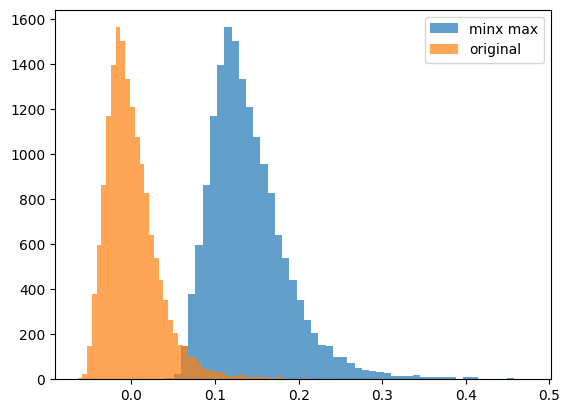

In [8]:
plt.hist(y_batch_scaled[0].numpy().flatten(), bins=50, alpha=0.7, label="minx max")
plt.hist(y_batch[0].numpy().flatten(), bins=50, alpha=0.7, label="original")
plt.legend()
plt.show()

La estadsitica tras convertir es mucho más compleja y no quiero gastar mucho tiempo si al final no es tan eficiente entrenando comparando a otros modelos.

así que dejo un link por si algun otro miembro del team se ve interesado

https://aegis4048.github.io/transforming-non-normal-distribution-to-normal-distribution

https://stats.stackexchange.com/questions/604840/how-to-convert-non-standard-lognormal-data-to-normal-scipy

In [13]:
y_batch_scaled_log = tf.math.log(y_batch_scaled)

C:\Users\fbien.DESKTOP-6FMEAR7\AppData\Local\Temp\ipykernel_16916\193595254.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


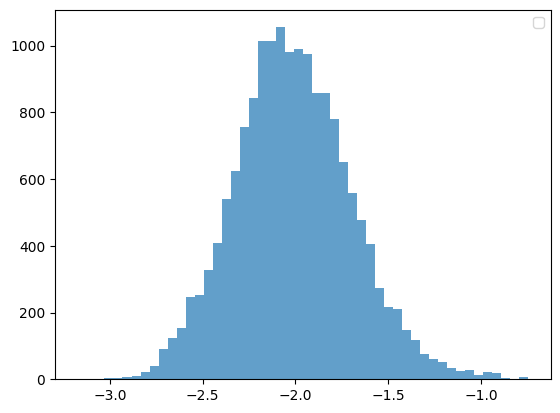

In [10]:
plt.hist(y_batch_scaled_log[0].numpy().flatten(), bins=50, alpha=0.7)

plt.legend()
plt.show()

In [19]:
from scipy import stats
data_for_testing_original = y_batch_scaled[0].numpy().flatten()
data_for_testing = y_batch_scaled_log[0].numpy().flatten()

Box-Cox

Best lambda parameter = -0.258


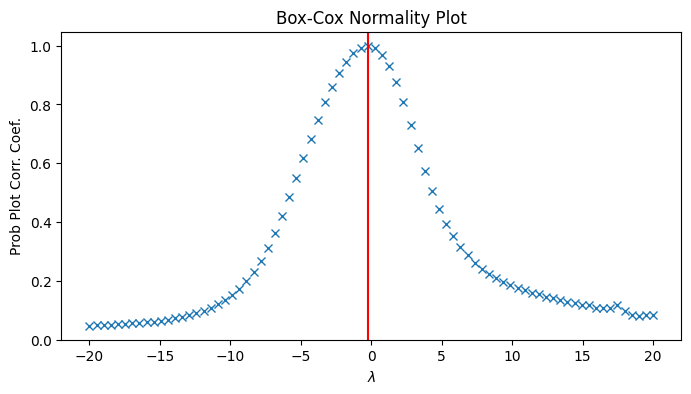

In [27]:
data_boxcox, lmbda = stats.boxcox(data_for_testing_original)

print('Best lambda parameter = %s' % round(lmbda, 3))

fig, ax = plt.subplots(figsize=(8, 4))
prob = stats.boxcox_normplot(data_for_testing_original, -20, 20, plot=ax)
ax.axvline(lmbda, color='r');

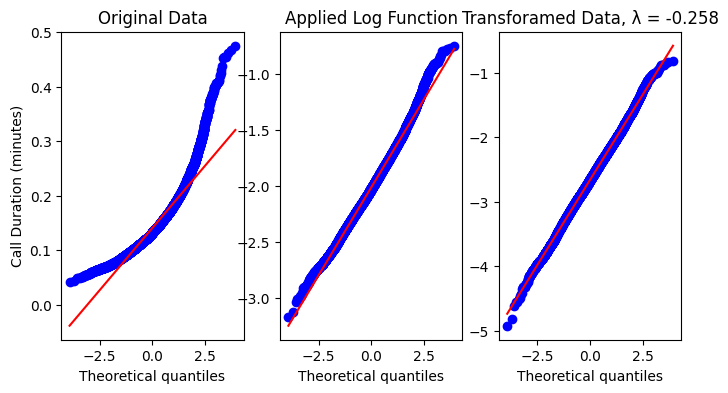

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4))

prob = stats.probplot(data_for_testing_original, dist=stats.norm, plot=ax1)
prob = stats.probplot(data_for_testing, dist=stats.norm, plot=ax2)
prob = stats.probplot(data_boxcox, dist=stats.norm, plot=ax3)


ax1.set_title('Original Data')
ax1.set_ylabel('Call Duration (minutes)')
ax2.set_title('Applied Log Function')
ax2.set_ylabel('');
ax3.set_title('Transforamed Data, λ = %s' %  round(lmbda, 3))
ax3.set_ylabel('');

Test de normalidad para el log transformation

In [17]:

k2, p = stats.normaltest(data_for_testing)
print('\nChi-squared statistic = %.3f, p = %.8f' % (k2, p))

alpha = 0.05
if p > alpha:
    print('\nThe transformed data is Gaussian (fails to reject the null hypothesis)')
else:
    print('\nThe transformed data does not look Gaussian (reject the null hypothesis)')


Chi-squared statistic = 223.160, p = 0.00000000

The transformed data does not look Gaussian (reject the null hypothesis)


Test de normalidad para el boxcos transformation

In [28]:
k2, p = stats.normaltest(data_boxcox)
print('\nChi-squared statistic = %.3f, p = %.3f' % (k2, p))

alpha = 0.05
if p > alpha:
    print('\nThe transformed data is Gaussian (fails to reject the null hypothesis)')
else:
    print('\nThe transformed data does not look Gaussian (reject the null hypothesis)')


Chi-squared statistic = 8.796, p = 0.012

The transformed data does not look Gaussian (reject the null hypothesis)


Transformar a Gaussianas no es una posibilidad, quizas existen outliers u otros factores que no se estan contando,
sin embargo el hecho de haber obtenido un MinMax Scaling ya es algo bastante util

# Gran Entrenamiento de MinxMax

In [2]:
from utils import CustomMinMaxScaler

minmaxscaler = CustomMinMaxScaler(feature_range=(0, 1))


In [3]:
from os.path import join
home_data = join("..", "data")
max_files = -1
batch_size = 32

train_dataset, val_dataset, test_dataset = get_datasets(data_index='1', max_files=max_files,
    home=home_data)

Using data folder: ..\data\1


In [4]:
# Testing con un batch
minmaxscaler.fit_scaler(train_dataset.take(1))

# Normalizar un batch de datos
for X_batch, y_batch in train_dataset.take(1):
    y_batch_scaled = minmaxscaler.transform(y_batch)
    print("Scaled batch:", y_batch_scaled.shape)

# Desescalar para volver a los valores originales
y_batch_original = minmaxscaler.inverse_transform(y_batch_scaled.numpy())
print("Original batch:", y_batch_original.shape)

assert y_batch_original.shape == y_batch_scaled.shape

Scaled batch: (32, 128, 128, 1)
Original batch: (32, 128, 128, 1)


In [5]:
import pickle
# Ajustar el scaler a los datos de entrenamiento
minmaxscaler.fit_scaler(train_dataset)


with open('minmaxscaler.pkl', 'wb') as f:
    pickle.dump(minmaxscaler, f)


In [ ]:
with open('minmaxscaler.pkl', 'rb') as f:
    minmaxscaler = pickle.load(f)

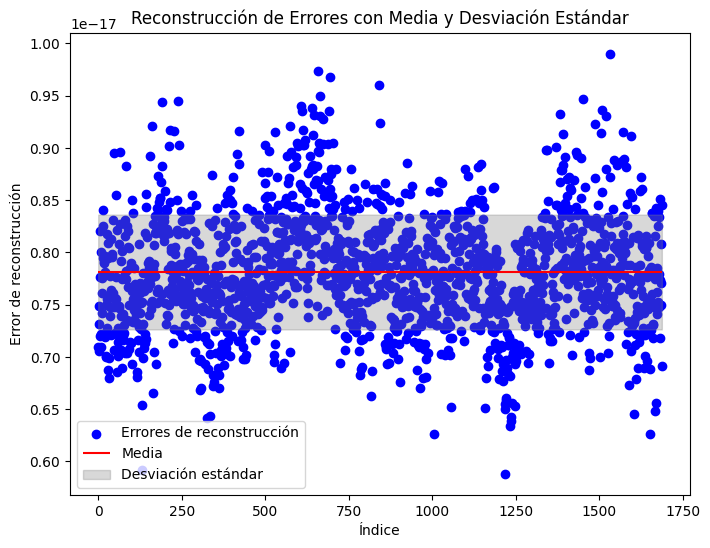

In [15]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Normalización y reconstrucción del batch
reconstruction_error_array = []

for X_batch, y_batch in train_dataset:
    y_batch_scaled = minmaxscaler.transform(y_batch)
    y_batch_reconstructed = minmaxscaler.inverse_transform(y_batch_scaled.numpy())
    
    # Aplanar los datos originales y reconstruidos para que sean 2D o 1D
    y_batch_flat = y_batch.numpy().reshape(-1)  # Convertir en 1D
    y_batch_reconstructed_flat = y_batch_reconstructed.reshape(-1)  # Convertir en 1D
    
    # Calcular el error de reconstrucción (MSE)
    reconstruction_error = mean_squared_error(y_batch_flat, y_batch_reconstructed_flat)
    reconstruction_error_array.append(reconstruction_error)

# Ahora puedes graficar los errores como antes
import matplotlib.pyplot as plt

mean_means = np.mean(reconstruction_error_array)
std_means = np.std(reconstruction_error_array)

plt.figure(figsize=(8, 6))
plt.scatter(range(len(reconstruction_error_array)), reconstruction_error_array, label="Errores de reconstrucción", color='blue')
plt.hlines(mean_means, xmin=0, xmax=len(reconstruction_error_array)-1, color='red', label='Media')
plt.fill_between(range(len(reconstruction_error_array)), 
                 mean_means - std_means, 
                 mean_means + std_means, 
                 color='gray', alpha=0.3, label='Desviación estándar')
plt.title("Reconstrucción de Errores con Media y Desviación Estándar")
plt.xlabel("Índice")
plt.ylabel("Error de reconstrucción")
plt.legend()
plt.show()


In [16]:
print(mean_means)
print(std_means)

7.812538e-18
5.491764e-19


El error se encuentra en la precisión de maquina, por tanto es una reconstrucción perfecta en lo que respecta